In [1]:
import os
import numpy as np
import cv2
import json 

# ------------------------------
# ENTER YOUR REQUIREMENTS HERE:
ARUCO_DICT = cv2.aruco.DICT_4X4_50
SQUARES_VERTICALLY = 5
SQUARES_HORIZONTALLY = 7
#SQUARE_LENGTH = 0.03  # in meters
#MARKER_LENGTH = 0.015  # in meters
SQUARE_LENGTH = 0.10 # in meters
MARKER_LENGTH = 0.08  # in meters
# ...
#PATH_TO_YOUR_IMAGES = 'testdata/charuco_calib_set_1/'
PATH_TO_YOUR_IMAGES = 'testdata/charuco_calib_gopro_02/'
print(f"{ARUCO_DICT=}")
# ------------------------------

json_file_path = './calibration.json'

with open(json_file_path, 'r') as file: # Read the JSON file
    json_data = json.load(file)

mtx = np.array(json_data['mtx'])
dst = np.array(json_data['dist'])

dictionary = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
board = cv2.aruco.CharucoBoard((SQUARES_VERTICALLY, SQUARES_HORIZONTALLY), SQUARE_LENGTH, MARKER_LENGTH, dictionary)
params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(dictionary, params)

ARUCO_DICT=0


In [2]:
image_paths = [os.path.join(PATH_TO_YOUR_IMAGES, f) for f in os.listdir(PATH_TO_YOUR_IMAGES) if f.endswith(".JPG")]

img_path = image_paths[2] # select image
image_color = cv2.imread(img_path)
image = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

h,  w = image.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dst, (w,h), 1, (w,h))
image = cv2.undistort(image, mtx, dst, None, newcameramtx)

all_charuco_ids = []
all_charuco_corners = []


marker_corners, marker_ids, rejectedCandidates = detector.detectMarkers(image)
if marker_ids is not None and len(marker_ids) > 0: # If at least one marker is detected
    # cv2.aruco.drawDetectedMarkers(image_copy, marker_corners, marker_ids)
    ret, charucoCorners, charucoIds = cv2.aruco.interpolateCornersCharuco(marker_corners, marker_ids, image, board)

    # note that return is pose of bord with camera at origin. to recover camera pose use -r^T @ tvec
    retval, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(charucoCorners, charucoIds, board, np.array(mtx), np.array(dst), np.empty(1), np.empty(1))
    try:
        Zx, Zy, Zz = tvec[0][0], tvec[1][0], tvec[2][0]
        fx, fy = mtx[0][0], mtx[1][1]
    except:
        print("error acessing tvec")

else:
    print("no marker detected")


In [3]:
%matplotlib widget

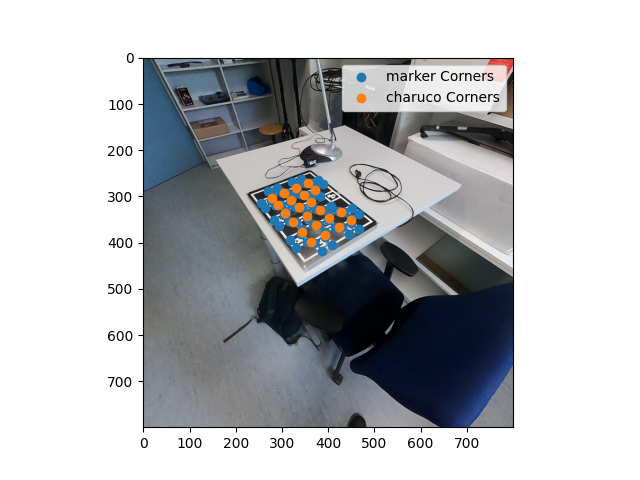

In [4]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.scatter(np.hstack(marker_corners)[0,:,0],np.hstack(marker_corners)[0,:,1],label="marker Corners")
try:
    plt.scatter(charucoCorners[:,0,0],charucoCorners[:,0,1], label="charuco Corners")
except:
    print("no charuco corners to plo")
plt.legend()

In [5]:
rotation_matrix, _ = cv2.Rodrigues(rvec)

# Camera pose: the inverse of the extrinsic matrix (rotation + translation)
camera_extrinsics = np.eye(4)
camera_extrinsics[:3, :3] = rotation_matrix
tvec = tvec.flatten()
#tvec = - rotation_matrix.T @ (tvec)
camera_extrinsics[:3, 3] = tvec
camera_mat = np.eye(4)
camera_mat[:3,:3] = mtx
P = camera_mat @ camera_extrinsics
P = P[:3,:] # we only had 4 rows for multiplication before
world_corners = board.getChessboardCorners()
image_pts = P @ np.hstack((world_corners,np.ones((world_corners.shape[0],1)))).T
# recover homogeneous coordinates
image_pts = image_pts / image_pts[-1,:]
image_pts = image_pts[:2,:]
image_pts.T

array([[272.45380851, 315.77562599],
       [300.75281334, 303.16567922],
       [328.82863412, 290.65518256],
       [356.68389456, 278.2429669 ],
       [290.43793401, 333.25095521],
       [318.70362647, 320.55480677],
       [346.74609959, 307.95892213],
       [374.56798099, 295.46212104],
       [308.47059351, 350.77344534],
       [336.7026914 , 337.9906763 ],
       [364.7115368 , 325.30899026],
       [392.49976122, 312.72719572],
       [326.5519797 , 368.34328361],
       [354.75019891, 355.47347262],
       [382.72513462, 342.70556936],
       [410.47942227, 330.038371  ],
       [344.68229305, 385.96066482],
       [372.84634752, 373.00338806],
       [400.78708968, 360.14884932],
       [428.50715885, 347.39583436],
       [362.86173783, 403.62578747],
       [390.99133955, 390.5806186 ],
       [418.89760237, 377.63902366],
       [446.58316944, 364.7997769 ]])

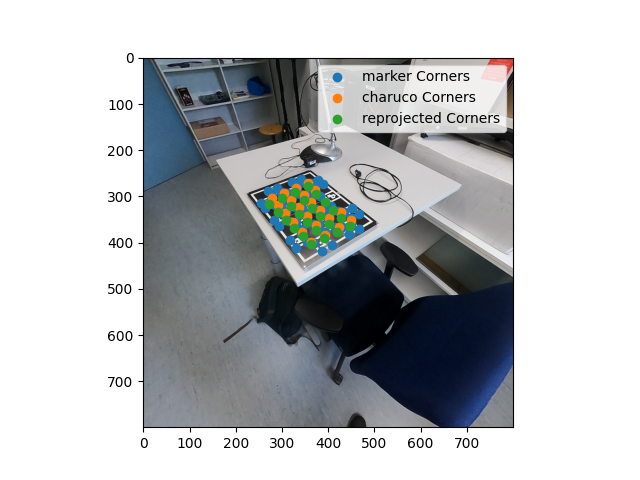

In [6]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.scatter(np.hstack(marker_corners)[0,:,0],np.hstack(marker_corners)[0,:,1],label="marker Corners")
plt.scatter(charucoCorners[:,0,0],charucoCorners[:,0,1], label="charuco Corners")
plt.scatter(image_pts[0,:],image_pts[1,:], label="reprojected Corners")
plt.legend()


successfully overlaid corners mean that returned rvec and tvec are indeed the camera pose. Note that because of opencv the image origin is top left.


In [7]:
image_pts

array([[272.45380851, 300.75281334, 328.82863412, 356.68389456,
        290.43793401, 318.70362647, 346.74609959, 374.56798099,
        308.47059351, 336.7026914 , 364.7115368 , 392.49976122,
        326.5519797 , 354.75019891, 382.72513462, 410.47942227,
        344.68229305, 372.84634752, 400.78708968, 428.50715885,
        362.86173783, 390.99133955, 418.89760237, 446.58316944],
       [315.77562599, 303.16567922, 290.65518256, 278.2429669 ,
        333.25095521, 320.55480677, 307.95892213, 295.46212104,
        350.77344534, 337.9906763 , 325.30899026, 312.72719572,
        368.34328361, 355.47347262, 342.70556936, 330.038371  ,
        385.96066482, 373.00338806, 360.14884932, 347.39583436,
        403.62578747, 390.5806186 , 377.63902366, 364.7997769 ]])

In [8]:
camera_extrinsics

array([[ 0.66731294,  0.73142587, -0.14039102, -8.16408138],
       [-0.67468496,  0.67350705,  0.30197426, -6.20640813],
       [ 0.31542613, -0.10679162,  0.942922  ,  7.91497657],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

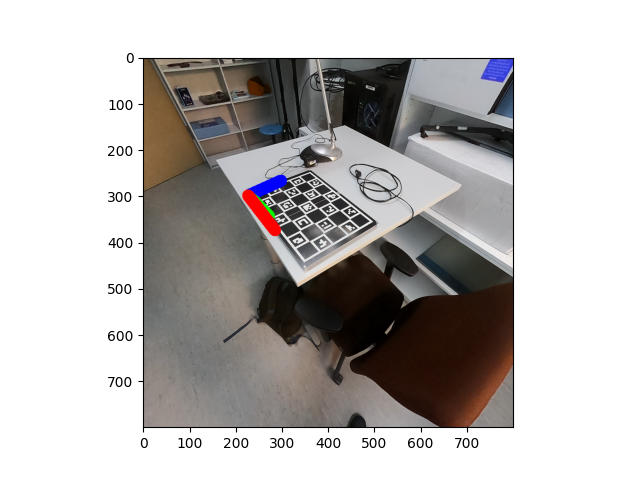

In [9]:
ic = cv2.drawFrameAxes(image_color.copy(), mtx,dst, rvec, tvec, 0.25, 25)
plt.figure()
plt.imshow(ic)
plt.show()

according to [docs](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#gab3ab7bb2bdfe7d5d9745bb92d13f9564) the axis conventions are x: red, y: green and z: blue.

In [10]:
import plotly.graph_objects as go
from stl import mesh
def plot_3d_points_and_camera_centers(points, extrinsic_matrices):
    """
    Plots a 3D scatter plot of the given points and camera representations from extrinsic matrices.

    Parameters:
    - points: A 3xN NumPy array, where each column represents a point (x, y, z).
    - extrinsic_matrices: A list of 4x4 NumPy arrays representing the extrinsic matrices for each camera.
    """
    # Ensure points is a NumPy array
    points = np.asarray(points)

    # Check if the input is a 3xN array
    if points.shape[0] != 3:
        raise ValueError("Input points must be a 3xN NumPy array.")

    # Extract x, y, z coordinates
    x = points[0, :]
    y = points[1, :]
    z = points[2, :]

    # Create a 3D scatter plot for the points
    fig = go.Figure(data=[go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=5,
            color='blue',  # Marker color for points
            opacity=0.8
        ),
        name='3D Points'
    )])

    def create_camera_cone(extrinsic, name):
        # Transform the cone points using the extrinsic matrix
        rotation_matrix = extrinsic[:3, :3].T
        camera_center = -rotation_matrix @ extrinsic[:3, 3]

        # def rotate_and_translate(vertices, rotation_matrix, translation_vector):
        #     # Apply rotation
        #     rotated_vertices = vertices @ rotation_matrix.T  # Ensure correct shape
        #     # Apply translation
        #     translated_vertices = rotated_vertices + translation_vector
        #     return translated_vertices

        # # Load the STL file
        # your_mesh = mesh.Mesh.from_file('pyramid.stl')

        # # Extract vertices
        # vertices = your_mesh.vectors.reshape(-1, 3)

        # # Rotate and translate the frustum
        # transformed_vertices = rotate_and_translate(vertices, rotation_matrix, camera_center)

        # # Compute forward vector 
        # frustum = go.Mesh3d(
        #     x=transformed_vertices[:, 0],
        #     y=transformed_vertices[:, 1],
        #     z=transformed_vertices[:, 2],
        #     opacity=0.75,
        #     color='blue'
        # )

        # Create axes representing the camera's orientation
        axes_length = 0.25
        x_axis = go.Scatter3d(
            x=[camera_center[0], camera_center[0] + axes_length * rotation_matrix[0, 0]],
            y=[camera_center[1], camera_center[1] + axes_length * rotation_matrix[1, 0]],
            z=[camera_center[2], camera_center[2] + axes_length * rotation_matrix[2, 0]],
            mode='lines',
            line=dict(color='red', width=5),
            name=name
        )

        y_axis = go.Scatter3d(
            x=[camera_center[0], camera_center[0] + axes_length * rotation_matrix[0, 1]],
            y=[camera_center[1], camera_center[1] + axes_length * rotation_matrix[1, 1]],
            z=[camera_center[2], camera_center[2] + axes_length * rotation_matrix[2, 1]],
            mode='lines',
            line=dict(color='green', width=5),
            name=name
        )

        z_axis = go.Scatter3d(
            x=[camera_center[0], camera_center[0] + axes_length * rotation_matrix[0, 2]],
            y=[camera_center[1], camera_center[1] + axes_length * rotation_matrix[1, 2]],
            z=[camera_center[2], camera_center[2] + axes_length * rotation_matrix[2, 2]],
            mode='lines',
            line=dict(color='blue', width=5),
            name=name
        )

        return [x_axis, y_axis, z_axis]

    # Plot camera representations from extrinsic matrices
    for idx, extrinsic in enumerate(extrinsic_matrices):
        # Create the camera cone
        cone_point_objects = create_camera_cone(extrinsic, f"cam_{idx}")

        # Add the cone to the plot
        [fig.add_trace(cone_points) for cone_points in cone_point_objects]

    # Set the layout
    fig.update_layout(
        title='3D Scatter Plot of Points and Camera Representations',
        scene=dict(
            xaxis_title='X Axis',
            yaxis_title='Y Axis',
            zaxis_title='Z Axis'
        )
    )

    # Show the figure in the Jupyter Notebook
    fig.show()


# Define a list of extrinsic matrices (4x4)
extrinsic_matrices = [
    camera_extrinsics
]

# Call the function to plot the points and camera representations
plot_3d_points_and_camera_centers(world_corners.T, extrinsic_matrices)

with xyz as rgb and x horizontal to right, y from top down and z camera facing forward

In [11]:
camera_extrinsics

array([[ 0.66731294,  0.73142587, -0.14039102, -8.16408138],
       [-0.67468496,  0.67350705,  0.30197426, -6.20640813],
       [ 0.31542613, -0.10679162,  0.942922  ,  7.91497657],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

now use validated code to estimate position of all cameras:

In [12]:
def reproject_world_points(rvec, tvec, mtx, world_corners):
    rotation_matrix, _ = cv2.Rodrigues(rvec)

    # Camera pose: the inverse of the extrinsic matrix (rotation + translation)
    E = np.eye(4)
    E[:3, :3] = rotation_matrix
    E[:3, 3] = tvec.flatten()
    camera_mat = np.eye(4)
    camera_mat[:3,:3] = mtx
    P = camera_mat @ E
    P = P[:3,:] # we only had 4 rows for multiplication before
    image_pts = P @ np.hstack((world_corners,np.ones((world_corners.shape[0],1)))).T
    # recover homogeneous coordinates
    image_pts = image_pts / image_pts[-1,:]
    image_pts = image_pts[:2,:]
    return E, P, image_pts

def estimate_pose(image_color, mtx, dst, detector):
    image = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

    h,  w = image.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dst, (w,h), 1, (w,h))
    image = cv2.undistort(image, mtx, dst, None, newcameramtx)

    all_charuco_ids = []
    all_charuco_corners = []


    marker_corners, marker_ids, rejectedCandidates = detector.detectMarkers(image)
    if marker_ids is not None and len(marker_ids) > 0: # If at least one marker is detected
        # cv2.aruco.drawDetectedMarkers(image_copy, marker_corners, marker_ids)
        ret, charucoCorners, charucoIds = cv2.aruco.interpolateCornersCharuco(marker_corners, marker_ids, image, board)

        retval, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(charucoCorners, charucoIds, board, np.array(mtx), np.array(dst), np.empty(1), np.empty(1))
        if retval == 0: 
            return None
        Zx, Zy, Zz = tvec[0][0], tvec[1][0], tvec[2][0]
        fx, fy = mtx[0][0], mtx[1][1]
        return rvec, tvec, charucoCorners
    else:
        return None
        #print("no marker detected")

In [13]:

from scipy.spatial import cKDTree
def compute_reprojection_error(reprojected_points, detected_points):
    # Create a KDTree for fast nearest neighbor search
    tree = cKDTree(detected_points)

    # Find the nearest detected point for each reprojected point
    distances, indices = tree.query(reprojected_points)

    # Calculate the reprojection error as the mean distance
    reprojection_error = np.mean(distances)

    return reprojection_error


In [14]:
def invert_transform(rotvec, tvec):
    # Step 1: Convert rotation vector to rotation matrix
    R, _ = cv2.Rodrigues(rotvec)

    # Step 2: Compute the inverse of the rotation matrix
    R_inv = R.T

    # Step 3: Convert the inverse rotation matrix back to a rotation vector
    rotvec_inv, _ = cv2.Rodrigues(R_inv)

    # Step 4: Compute the inverse translation vector
    tvec_inv = -R_inv @ tvec
    return rotvec_inv, tvec_inv

def draw_reproj(image_color, charucoCorners, image_pts):
    f = plt.figure()
    ax = f.add_subplot(111)
    ax.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
    #plt.scatter(np.hstack(marker_corners)[0,:,0],np.hstack(marker_corners)[0,:,1],label="marker Corners")
    ax.scatter(charucoCorners[:,0,0],charucoCorners[:,0,1], label="charuco Corners")
    ax.scatter(image_pts[0,:],image_pts[1,:], label="reprojected Corners")
    ax.legend()
    plt.close(f)
    return f

def convert_left_to_right(rvec, tvec):
    # Convert rotation vector to rotation matrix
    R, _ = cv2.Rodrigues(rvec)

    # Invert the z-axis for the rotation matrix
    R[:, 2] = -R[:, 2]

    # Convert back to rotation vector
    rvec_right = cv2.Rodrigues(R)[0]

    # Invert the z-component of the translation vector
    tvec_right = tvec.copy()
    tvec_right[2] = -tvec_right[2]

    return rvec_right, tvec_right

In [15]:
REPROJECTION_ERROR_THRESH = 10000.0
dictionary = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
board = cv2.aruco.CharucoBoard((SQUARES_VERTICALLY, SQUARES_HORIZONTALLY), SQUARE_LENGTH, MARKER_LENGTH, dictionary)
params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(dictionary, params)
world_corners = board.getChessboardCorners()

camera_poses = []
figures = []
for i, image_path in enumerate(image_paths):
    #img_path = image_paths[12] # select image
    #print(image_path)
    image_color = cv2.imread(image_path)
    res = estimate_pose(image_color, mtx, dst, detector)
    if res is None:
        print("pose could not be estimated")
        continue
    rvec, tvec, charuco_corners = res
    #rvec, tvec = convert_left_to_right(rvec, tvec)
    #rvec, tvec = invert_transform(rvec, tvec)
    E, P, img_pts = reproject_world_points(rvec, tvec, mtx, world_corners)
    #print(charuco_corners[:2,0,:])
    repr_err = compute_reprojection_error(charuco_corners, img_pts.T)
    if repr_err < REPROJECTION_ERROR_THRESH:
        camera_poses.append(E)
        figures.append(draw_reproj(image_color, charuco_corners, img_pts))
    print(i, image_path,repr_err)


plot_3d_points_and_camera_centers(world_corners.T, camera_poses)


pose could not be estimated
1 testdata/charuco_calib_gopro_02/GS__0011_0.JPG 10.799597864861722
2 testdata/charuco_calib_gopro_02/GS__0012_0.JPG 11.975392614817594
3 testdata/charuco_calib_gopro_02/GS__0013_0.JPG 11.219608675250676
pose could not be estimated
5 testdata/charuco_calib_gopro_02/GS__0015_0.JPG 18.538982915039384
6 testdata/charuco_calib_gopro_02/GS__0016_0.JPG 17.944978784778904


appareantly when converting rvec and tvec into extrinsics the resulting pose matrix is the proper pose which has the board in the origin already

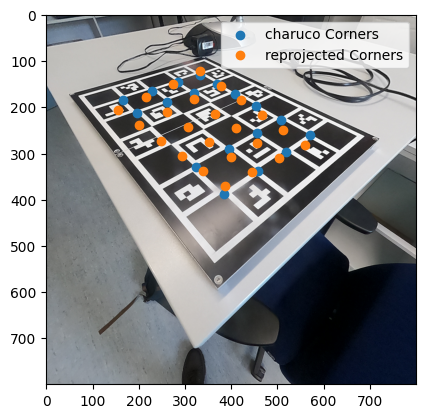

In [16]:
#camera_poses[10:12]
figures[3]